# RhizoScan Pipeline

This pipeline is a step by step pipeline

## Common import

In [31]:
%pylab inline
from matplotlib import pyplot as plt
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


/home/lessy/miniconda2/envs/rhizoscan/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## RhizoScan Import

In [32]:
from rhizoscan import get_data_path
from rhizoscan.root.pipeline import load_image, detect_petri_plate, compute_graph, compute_tree
from rhizoscan.root.pipeline.arabidopsis import segment_image, detect_leaves
from rhizoscan.root.graph.mtg import tree_to_mtg

In [33]:

from skimage import  io
from skimage import filters
import skimage.measure
import numpy as np
import cv2
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from sklearn.cluster import KMeans

######################### load image ###########################################
from skimage.io import imread, call_plugin, plugin_info
from skimage.util.dtype import convert


In [34]:
from cv2 import erode as _erode
from sklearn.cluster import KMeans as _Kmeans

import numpy as _np
import scipy as _sp
from scipy import ndimage as _nd

from rhizoscan.workflow import node as _node         # declare workflow nodes
from rhizoscan.workflow import pipeline as _pipeline # declare workflow pipeline

from rhizoscan.ndarray.measurements import clean_label as _clean_label
from rhizoscan.image                import Image       as _Image


## RSA Image

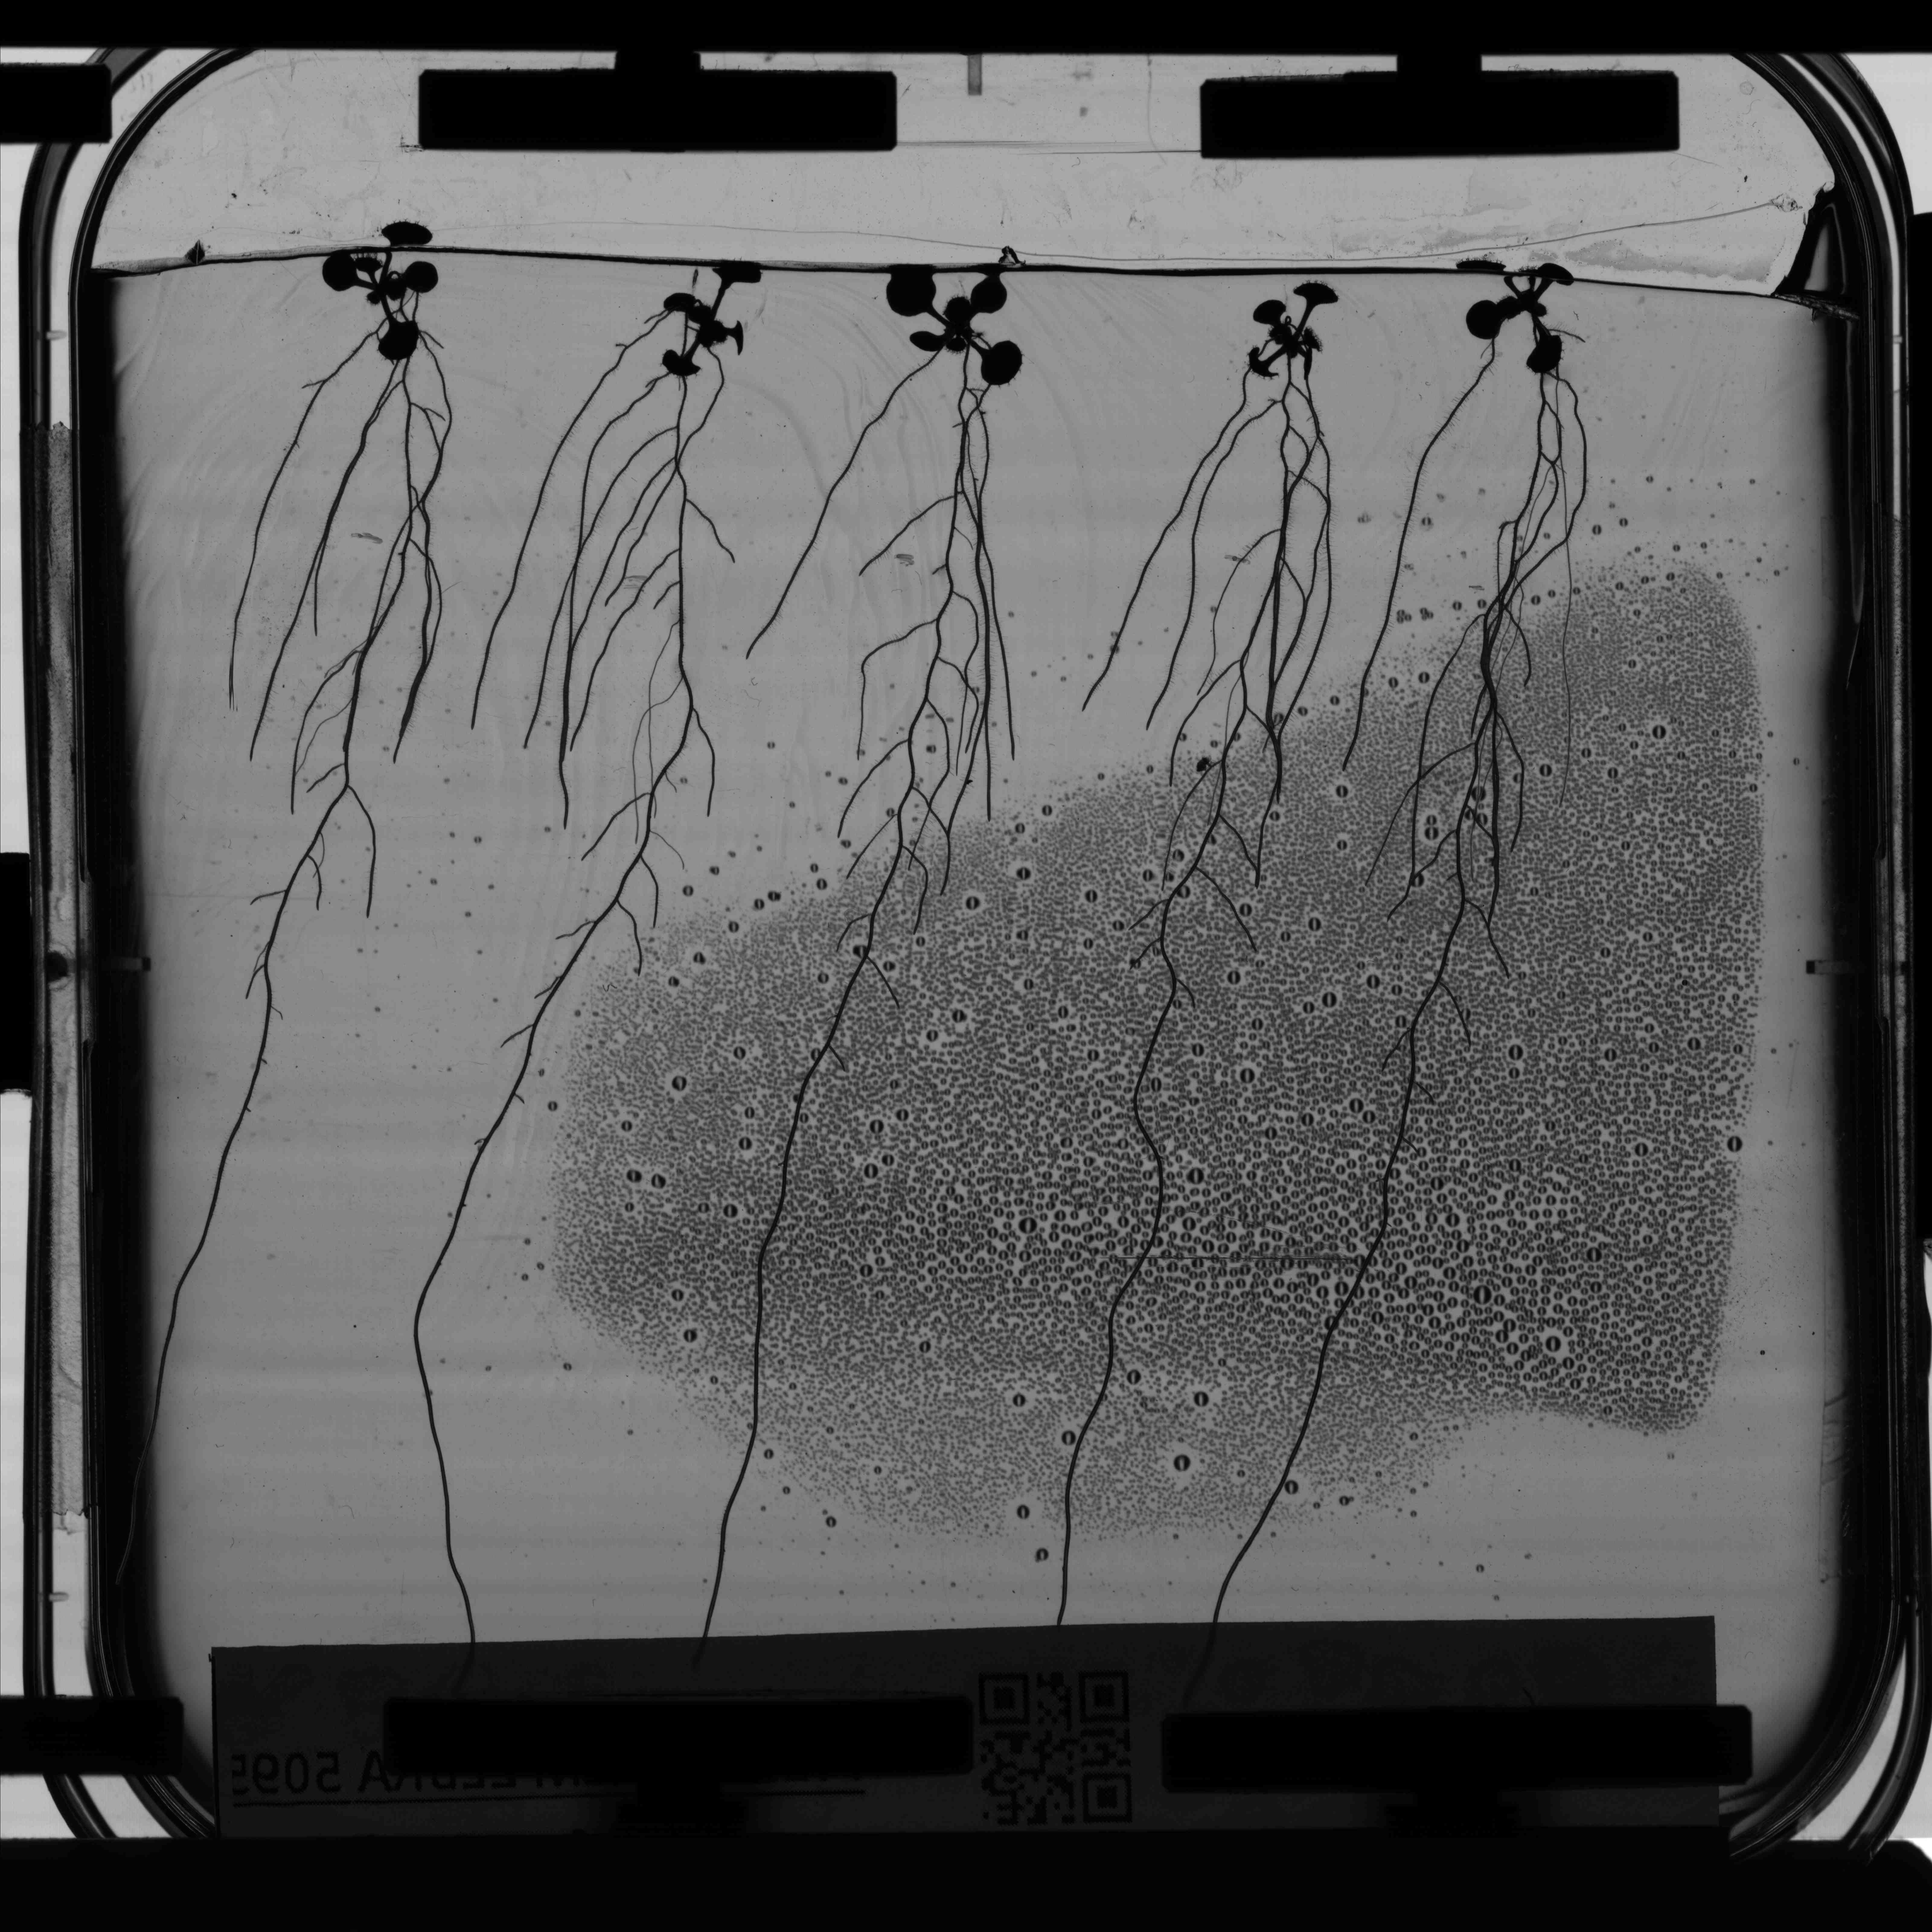

In [35]:
image_filename = get_data_path('pipeline/big_root.jpg')
Image(image_filename)

### Load Image

In [36]:
image = load_image(image_filename)

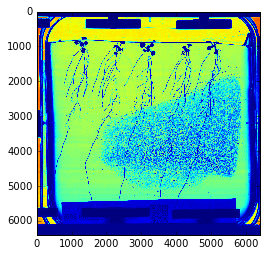

In [37]:
image = imread(image_filename)
#image = image.astype(_np.uint8)
#image.dtype
#image = convert(image,dtype = _np.uint8)
imshow(image)

## crop image 

In [56]:
image[5000:,:]   = 0 
image[:660,:]    = 0
image[: , :750]  = 0
image[: , 5500:] = 0 

## image filter

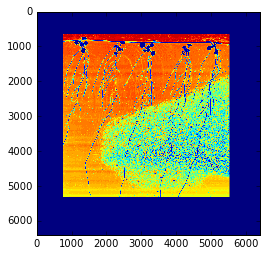

In [39]:
image = cv2.morphologyEx(image,cv2.MORPH_OPEN,(25,25))
imshow(image)

### Detect features (Petri plate)

0.0297829805978


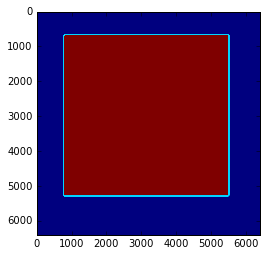

In [40]:
pmask, px_scale, hull = detect_petri_plate(image,border_width=35, plate_size=140, fg_smooth=1)
print px_scale
imshow(pmask)

## Segmentation Threshold

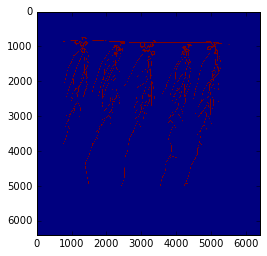

In [41]:
rmask = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,101,25)

label_image = skimage.measure.label(rmask)
regions     = skimage.measure.regionprops(label_image)

#certaintly the best methods is to kept the area superior to a x define value

region = max(regions,key = lambda x: x.area)
rmask = label_image.copy()

rmask[rmask != region.label] = 0

rmask[rmask > 0 ] = 255 

rmask[5000: ,:] = 0 
rmask[:660 , :] = 0
rmask[: , :750] = 0
rmask[: ,5500:] = 0 

imshow(rmask)


## Kept biggest connected component 

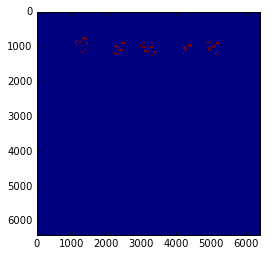

In [57]:
kernel = np.ones((4,4))

image = cv2.morphologyEx(rmask.astype(np.uint8),cv2.MORPH_OPEN, kernel, iterations = 10)
    
image[5000: ,:] = 0 
image[:660 , :] = 0
image[: , :750] = 0
image[: ,5500:] = 0 

imshow(image)

## detect leaves and seed 

In [58]:
for i in range(5):
    label_image1 = skimage.measure.label(np.array(image))
    regions1     = skimage.measure.regionprops(label_image1)


In [59]:
region1 = max(regions1,key = lambda x: x.area)
image = label_image1.copy()

In [60]:
plant_number = 5
x, y = _np.where(image > 0)

pts = list()
for xx, yy in zip(x, y):
    pts.append((xx, yy))

pts = _np.array(pts, dtype=float)

kmeans = _Kmeans(n_clusters=plant_number).fit(pts)
label = kmeans.labels_

pts = pts.astype(int)

for (x, y), label in zip(list(pts), label):
    image[x, y] = int(label) + 1


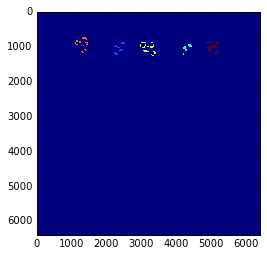

In [61]:
imshow(image)


### Compute the graph corresponding to the RSA

### Extract a tree from the graph

### Save the RSA into an MTG